# Intro to Autoencoders

We will explore autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds  # Add this import

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

2025-10-18 22:57:18.202057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 22:57:18.274530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 22:57:19.816053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
# Load MNIST dataset using tfds
ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
(ds_train, ds_test) = ds

# Convert to numpy arrays
def preprocess_mnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Apply preprocessing and convert to numpy
x_train = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_train])
x_test = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_test])

print(x_train.shape)  # Should be (60000, 28, 28, 1)
print(x_test.shape)   # Should be (10000, 28, 28, 1)

/home/zkhechadoorian/GANs_architecture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]2025-10-18 22:57:23.426763: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-18 22:57:44.951607: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Dataset mnist downloaded and prepared to /home/zkhechadoorian/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2025-10-18 22:58:11.742493: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(60000, 28, 28, 1)
(10000, 28, 28, 1)


2025-10-18 22:58:16.285315: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


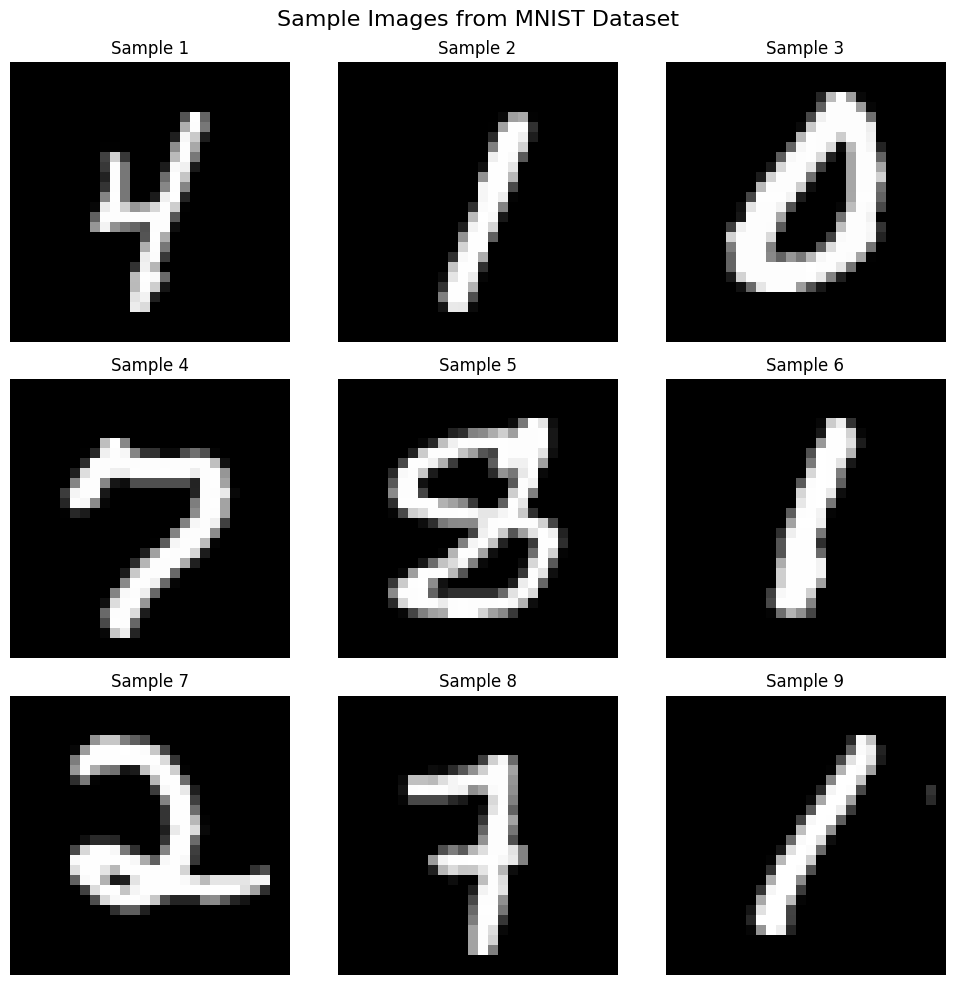

In [3]:
# Display a 3x3 grid of sample MNIST digits
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')  # Use .squeeze() and cmap='gray'
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle("Sample Images from MNIST Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Print comprehensive dataset statistics
print("=== MNIST Dataset Statistics ===")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Image dimensions: {x_train.shape[1]} x {x_train.shape[2]} pixels")
print(f"Number of channels: {x_train.shape[3]} (Grayscale)")
print(f"Total training samples: {x_train.shape[0]:,}")
print(f"Total test samples: {x_test.shape[0]:,}")
print(f"Data type: {x_train.dtype}")
print(f"Pixel value range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Memory usage (training): {x_train.nbytes / (1024**2):.1f} MB")
print(f"Memory usage (test): {x_test.nbytes / (1024**2):.1f} MB")

# MNIST class names (digits 0-9)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

=== MNIST Dataset Statistics ===
Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Image dimensions: 28 x 28 pixels
Number of channels: 1 (Grayscale)
Total training samples: 60,000
Total test samples: 10,000
Data type: float32
Pixel value range: [0.000, 1.000]
Memory usage (training): 179.4 MB
Memory usage (test): 29.9 MB
Number of classes: 10
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## First example: Basic autoencoder
![Basic autoencoder results](https://www.tensorflow.org/static/tutorials/generative/images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [5]:
# Define an Autoencoder class inheriting from tf.keras.Model
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()  # Initialize the base class
    self.latent_dim = latent_dim         # Store the size of the latent space
    self.shape = shape                   # Store the original input shape

    # Encoder: flattens input and encodes to latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # Flatten input to 1D
      layers.Dense(latent_dim, activation='relu'),  # Dense layer for encoding
    ])

    # Decoder: reconstructs original shape from latent vector
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),  # Dense layer to expand back to original size
      layers.Reshape(shape)               # Reshape output to original input shape
    ])

  # Forward pass: encode then decode
  def call(self, x):
    encoded = self.encoder(x)             # Encode input
    decoded = self.decoder(encoded)       # Decode latent vector
    return decoded                        # Return reconstruction

# Set the shape and latent dimension for the autoencoder
shape = x_test.shape[1:]                  # Get shape of input images (e.g., (28, 28))
latent_dim = 64                           # Set size of latent space

# Instantiate the Autoencoder model
autoencoder = Autoencoder(latent_dim, shape)


Mean Squared Error (MSE) is commonly used as the loss function for autoencoders working with images because it measures the average squared difference between the original and reconstructed pixel values. This is appropriate for images because:

- **Pixel-wise similarity:** MSE penalizes large differences between corresponding pixels, encouraging the autoencoder to produce reconstructions that are visually similar to the input.
- **Continuous values:** Image data is often represented as continuous values (e.g., pixel intensities between 0 and 1), making MSE a natural choice.
- **Smooth gradients:** MSE provides smooth and stable gradients, which helps neural networks learn effectively during training.

In summary, MSE is simple, effective, and aligns well with the goal of minimizing reconstruction error in image autoencoders.

In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0241 - val_loss: 0.0094
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0040 - val_loss: 0.0039


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [8]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

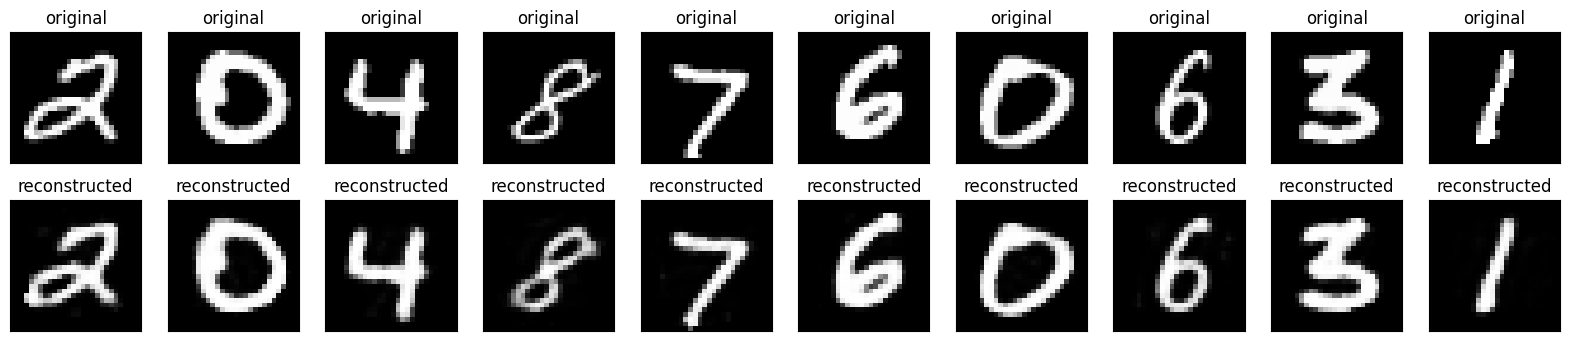

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

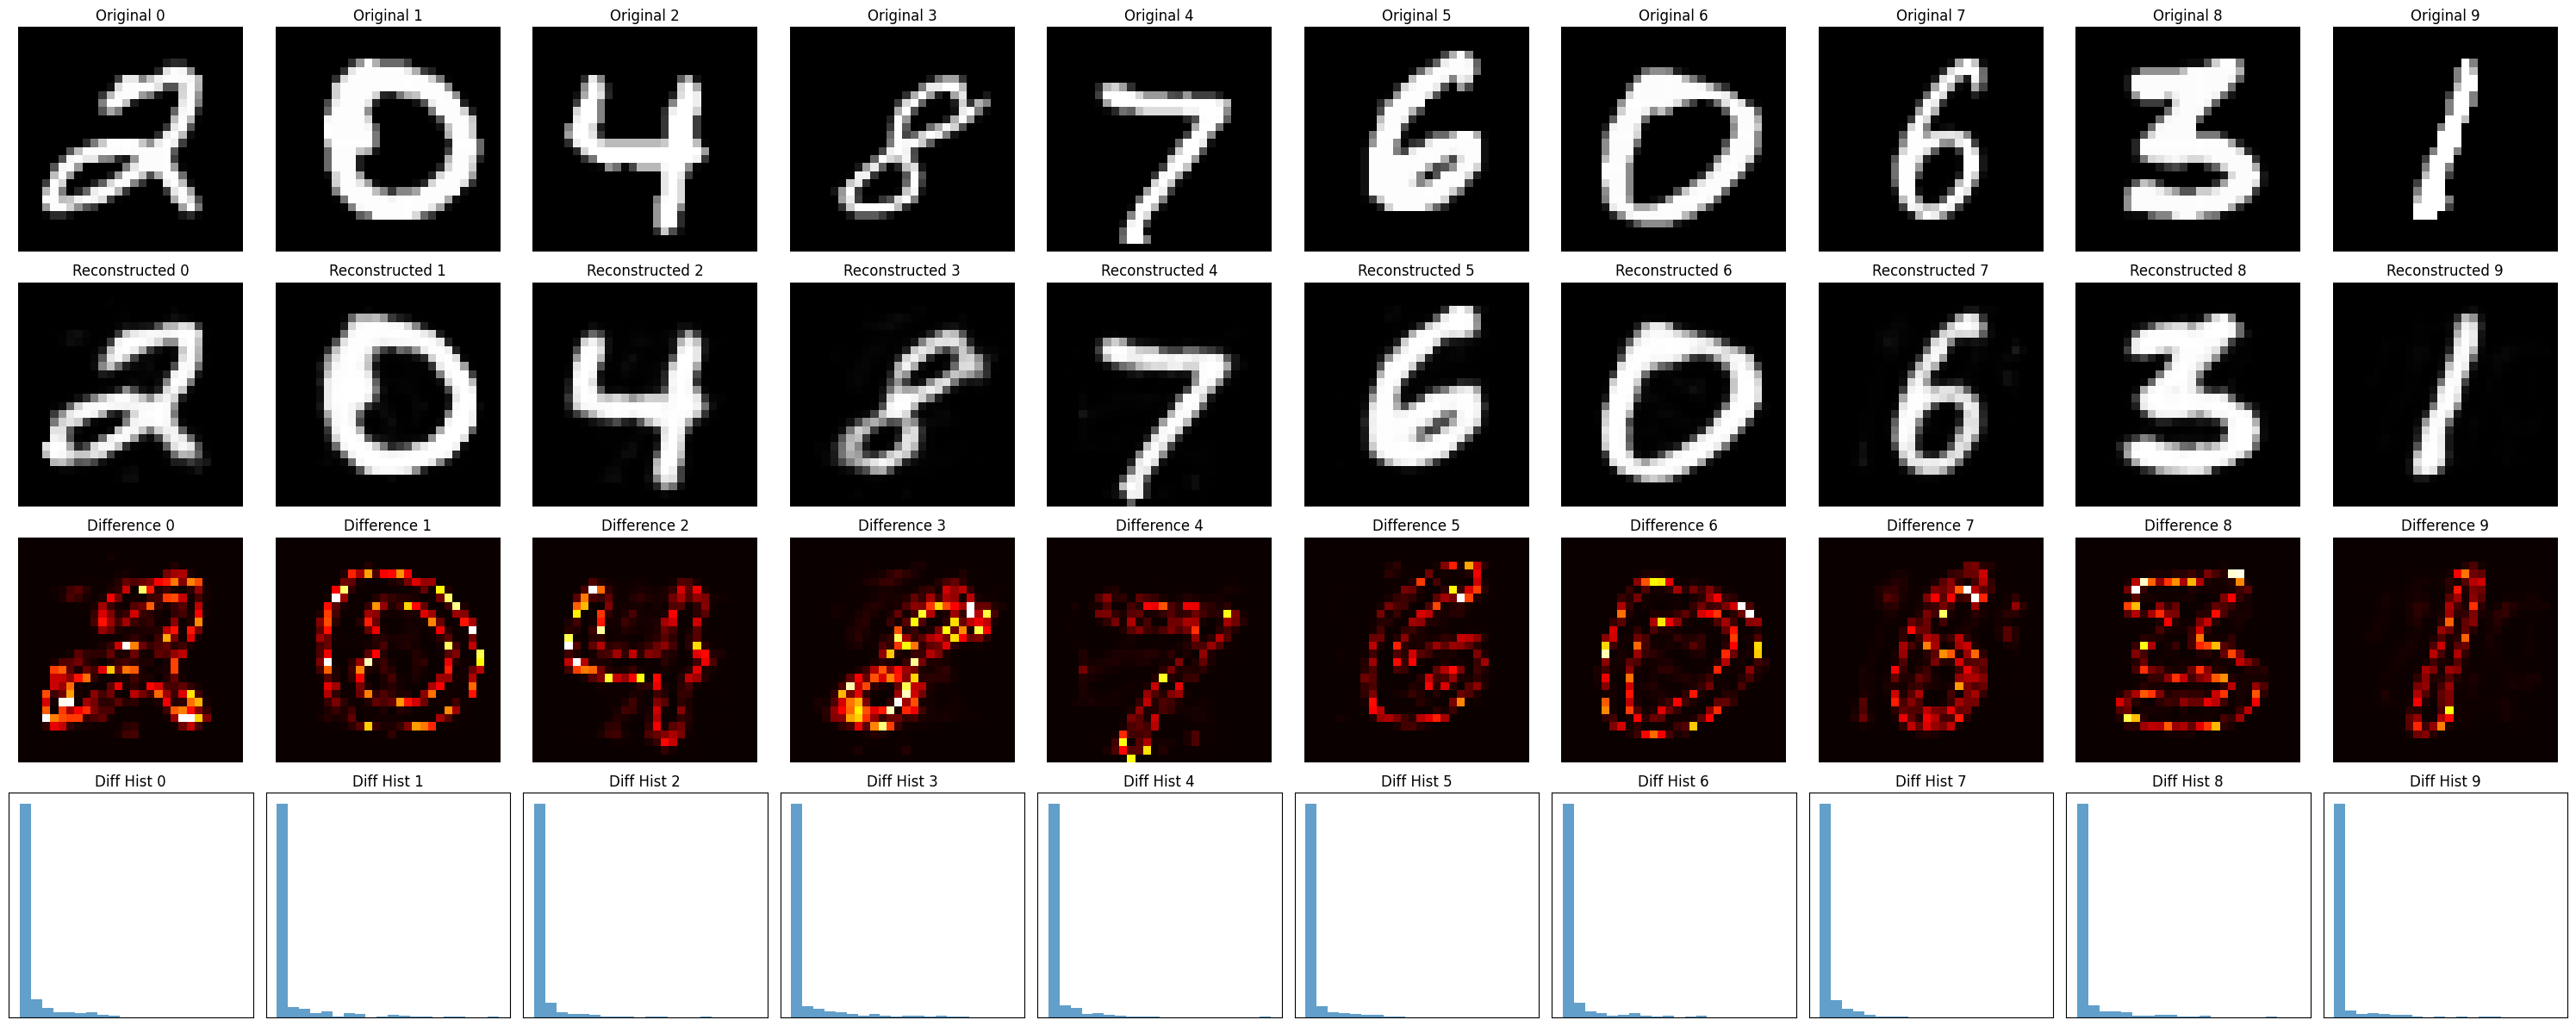

In [ ]:
# Calculate pixel-wise differences
differences = np.abs(x_test[:10] - decoded_imgs[:10])

plt.figure(figsize=(30, 12))
for i in range(10):
    # Original
    plt.subplot(4, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(4, 10, i + 11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Reconstructed {i}")
    plt.axis('off')
    
    # Difference heatmap
    plt.subplot(4, 10, i + 21)
    plt.imshow(differences[i].squeeze(), cmap='hot', vmin=0, vmax=0.5)
    plt.title(f"Difference {i}")
    plt.axis('off')
    
    # Difference histogram
    plt.subplot(4, 10, i + 31)
    plt.hist(differences[i].flatten(), bins=20, alpha=0.7)
    plt.title(f"Diff Hist {i}")
    plt.xticks([]) 
    plt.yticks([])

plt.tight_layout()
plt.show()

## Interpreting the Difference Analysis

### Understanding the Difference Heatmaps
The **difference heatmaps** (third row) show the absolute pixel-wise differences between original and reconstructed images using a "hot" colormap:
- **Dark/Black areas**: Pixels with little to no difference (good reconstruction)
- **Bright/Yellow-Red areas**: Pixels with large differences (poor reconstruction)

**Key Observation**: The brightest regions typically appear at the **edges and boundaries** of each digit. This indicates that the autoencoder struggles most with fine details and sharp transitions between foreground (digit) and background pixels. The model tends to blur or smooth these edge regions during reconstruction.

### Understanding the Difference Histograms
The **difference histograms** (bottom row) show the distribution of pixel-wise differences for each image:

**X-axis**: Difference values (ranging from 0 to ~0.5)
- 0 = Perfect reconstruction (no difference)
- Higher values = Larger reconstruction errors

**Y-axis**: Count of pixels with that difference value

**Key Observations**:
1. **Largest bin at 0**: Most pixels have zero or near-zero difference, indicating the autoencoder successfully reconstructs the majority of pixels
2. **Right-skewed distribution**: Few pixels have large errors, confirming that major reconstruction issues are localized to specific regions (mainly edges)
3. **Long tail**: Some pixels have moderate to high errors, representing the edge artifacts and fine detail losses

This analysis confirms that while the autoencoder performs well overall, it systematically struggles with preserving sharp edges and fine details - a common limitation of

## Second example: Image denoising


![Image denoising results](https://www.tensorflow.org/static/tutorials/generative/images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [ ]:
noise_factor = 0.2  # Set the amount of noise to add

# Add random Gaussian noise to the training images
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
# Add random Gaussian noise to the test images
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# Clip the noisy training images to be between 0 and 1
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
# Clip the noisy test images to be between 0 and 1
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


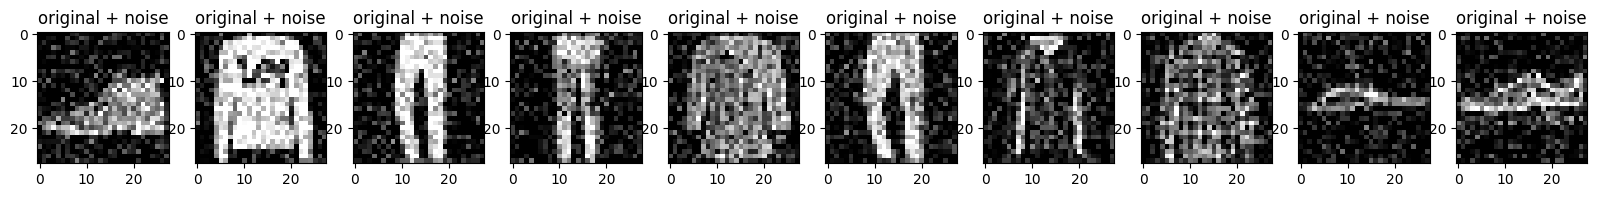

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

`Conv2DTranspose` is a type of convolutional layer often called a "deconvolution" or "upsampling" layer. It performs the reverse operation of a standard `Conv2D` layer: instead of reducing the spatial dimensions (height and width) of the input, it increases them.

- **Conv2D**: Used in the encoder part of an autoencoder to extract features and reduce the spatial size of the input (downsampling).
- **Conv2DTranspose**: Used in the decoder part to reconstruct the original image size from the compressed representation (upsampling).

**Why not use Conv2D in the decoder?**

- `Conv2D` reduces spatial dimensions, which is the opposite of what we want in the decoder.
- The decoder needs to upsample (increase) the spatial dimensions to reconstruct the original image, which is exactly what `Conv2DTranspose` does.

In summary, use `Conv2D` for downsampling (encoder) and `Conv2DTranspose` for upsampling (decoder) in convolutional autoencoders.

In [ ]:
# Define a convolutional autoencoder model for image denoising
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()  # Initialize the base Model class

    # Define the encoder as a Sequential model
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),  # Input layer for 28x28 grayscale images
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),  # Downsample with 16 filters
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)    # Further downsample with 8 filters
    ])

    # Define the decoder as a Sequential model
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),   # Upsample with 8 filters
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),  # Further upsample with 16 filters
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')                # Output layer to reconstruct the image
    ])

  # Define the forward pass
  def call(self, x):
    encoded = self.encoder(x)   # Pass input through encoder
    decoded = self.decoder(encoded)  # Pass encoded output through decoder
    return decoded             # Return the reconstructed image

# Instantiate the Denoise autoencoder model
autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0172 - val_loss: 0.0097
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0070 - val_loss: 0.0071


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

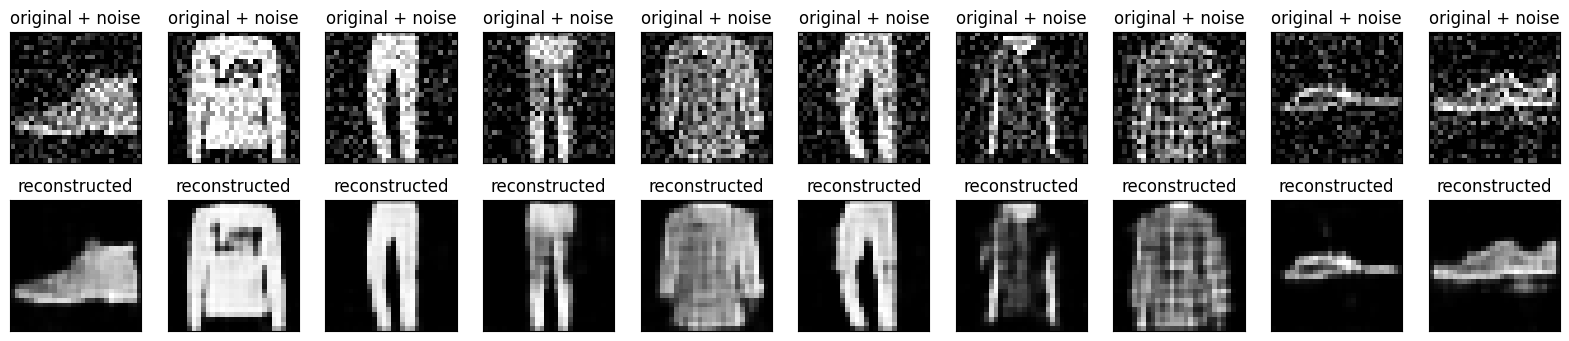

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


**What is ECG data?**

ECG (Electrocardiogram) data is a time series recording of the electrical activity of the heart. Each ECG sample typically consists of a sequence of voltage measurements taken at regular intervals, representing the heart's rhythm and electrical conduction patterns. These signals are used by clinicians to detect and diagnose various cardiac conditions, such as arrhythmias, heart attacks, and other abnormalities.

In machine learning, ECG data is often represented as a 1D array (or vector) of numerical values, where each value corresponds to the electrical potential measured at a specific time point. For example, in the ECG5000 dataset used above, each ECG record contains 140 data points. The dataset may also include labels indicating whether the rhythm is normal or abnormal, which can be used for supervised or unsupervised learning tasks such as anomaly detection.

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

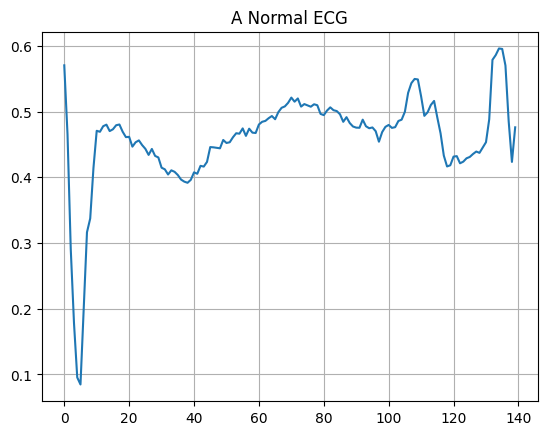

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

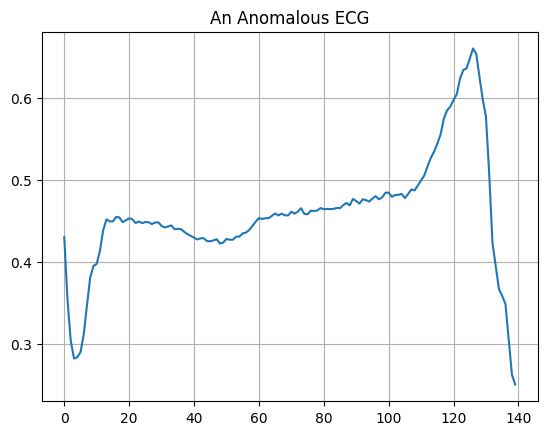

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0589 - val_loss: 0.0537
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0570 - val_loss: 0.0528
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0542 - val_loss: 0.0499
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0516 - val_loss: 0.0480
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0483 - val_loss: 0.0464
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0448 - val_loss: 0.0455
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0414 - val_loss: 0.0436
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0381 - val_loss: 0.0418
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0352 - val_loss: 0.0408
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0325 - val_loss: 0.0396
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0301 - val_loss: 0.0386
Epoch 13/20


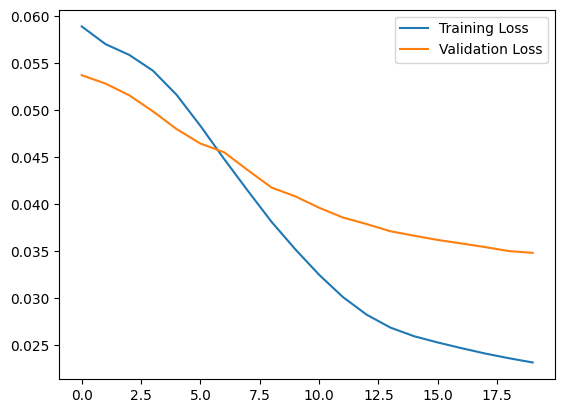

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

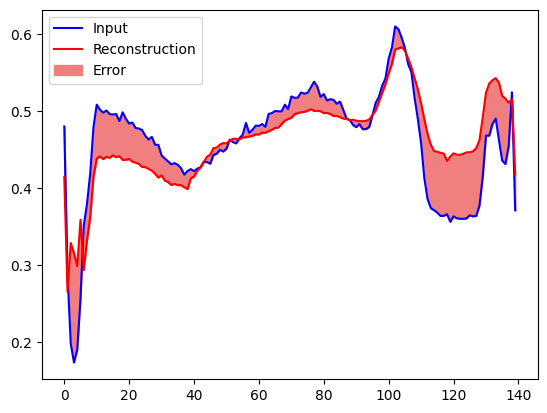

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

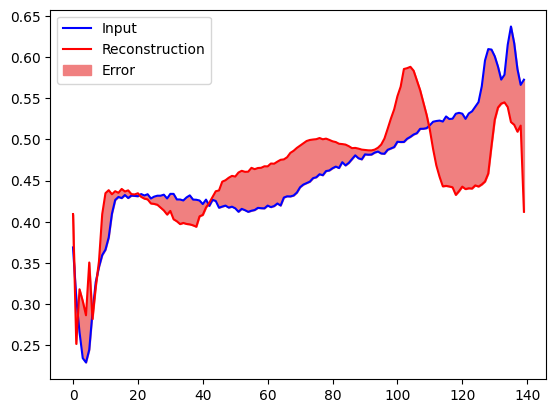

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


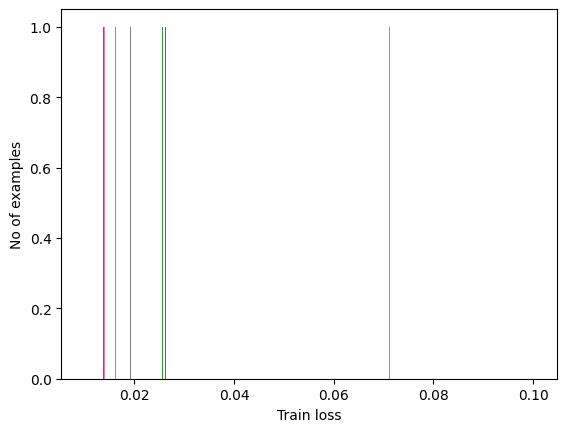

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03481799


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


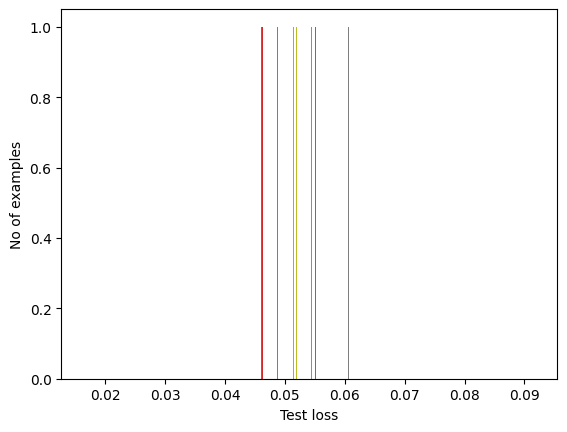

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  # Use the model to reconstruct the input data
  reconstructions = model(data)
  # Calculate the mean absolute error between the reconstructions and the original data
  loss = tf.keras.losses.mae(reconstructions, data)
  # Return True if the loss is less than the threshold (i.e., normal), otherwise False (anomaly)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  # Print the accuracy of the predictions compared to the true labels
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  # Print the precision of the predictions
  print("Precision = {}".format(precision_score(labels, predictions)))
  # Print the recall of the predictions
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
